<a href="https://colab.research.google.com/github/JYEmm-eng/Final-Team9/blob/main/director1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np

In [17]:
df=pd.read_csv("/content/drive/MyDrive/Movie/TMDB_processed (1).csv")

In [18]:
df

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords,director,cast,ROI,SR
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,160000000,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.9520,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...",415.957978,3
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,165000000,tt0816692,en,Interstellar,The adventures of a group of explorers who mak...,140.2410,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Michael Ca...",325.290428,3
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,185000000,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.6430,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...",Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",443.004564,3
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,237000000,tt0499549,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.9320,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ...",James Cameron,"Sam Worthington, Zoe Saldaña, Sigourney Weaver...",1133.631235,3
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,220000000,tt0848228,en,The Avengers,When an unexpected enemy emerges and threatens...,98.0820,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com...",Joss Whedon,"Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",590.370689,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9102,1511199,Lily Chou-Chou LIVE U-Next 2023,10.000,1,Released,2023-10-21,10000,0,False,1000,NaN,ja,Lily Chou-Chou LIVE U-Next 2023,NaN,0.1143,NaN,Music,U-NEXT,Japan,Japanese,japanese music,Kyōichi Shiino,"Salyu, Takeshi Kobayashi, Yukio Nagoshi, Maki ...",900.000000,3
9103,1127529,The Unanswered Question III : Musical Semantics,9.000,1,Released,1976-01-11,2000,143,False,1000,tt0925075,en,The Unanswered Question III : Musical Semantics,"This series comprised six lectures on music, w...",0.6000,Bernstein at Harvard,"Documentary, Music",Harvard Productions,United States of America,English,"poetry, harvard university, linguistics, music...",Humphrey Burton,Leonard Bernstein,100.000000,1
9104,1034243,Helpline!,8.000,1,Released,2004-01-10,500,5,False,100,tt0489075,en,Helpline!,Calling a helpline sometimes causes more probl...,0.6000,Calling a helpline sometimes causes more probl...,Animation,Jirosworld,Netherlands,English,"lgbt, short film",Jiro Ghianni,NaN,400.000000,3
9105,1127534,The Unanswered Question IV : The Delights and ...,9.000,1,Released,1976-01-11,2000,143,False,1000,tt1834864,en,The Unanswered Question IV : The Delights and ...,"This series comprised six lectures on music, w...",0.6200,Bernstein at Harvard,"Documentary, Music",Harv

In [23]:
df["production_companies"].unique()


array(['Legendary Pictures, Syncopy, Warner Bros. Pictures',
       'Legendary Pictures, Syncopy, Lynda Obst Productions',
       'DC Comics, Legendary Pictures, Syncopy, Isobel Griffiths, Warner Bros. Pictures',
       ..., 'U-NEXT', 'Jirosworld', 'NGHTMR Studios'], dtype=object)

In [5]:
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

sr이2 이상, roi가 250% 이상의 감독중에 상위 20%의 popularity가있는 감독의 roi가 높을 것이다. 가설 검증을 위해 인기도를 상위25%, 중위50% 하위25%로 나누어 아노바검정, 로그스케일비교

사분위 그룹 분포:
 인기도_사분위
중간50    788
하위25    394
상위25    394
Name: count, dtype: int64

[ANOVA] F = 0.8754444978706754 , p = 0.41687968028700495

[ANOVA: statsmodels]
                   sum_sq      df         F   PR(>F)
C(인기도_사분위)  1.108705e+14     2.0  0.875444  0.41688
Residual    9.960613e+16  1573.0       NaN      NaN

[Tukey HSD]
        Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff  p-adj     lower        upper     reject
-----------------------------------------------------------------
  상위25   중간50 192615.5914 0.9187 -959219.7915 1344450.9743  False
  상위25   하위25 713404.2284 0.4191 -616620.7083 2043429.1652  False
  중간50   하위25  520788.637 0.5387 -631046.7458 1672624.0199  False
-----------------------------------------------------------------


<Figure size 600x400 with 0 Axes>

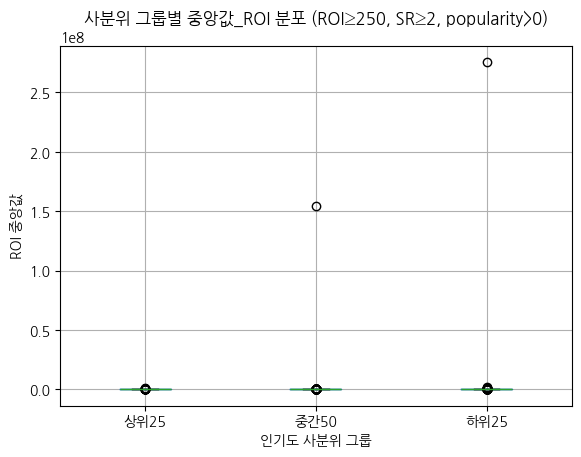

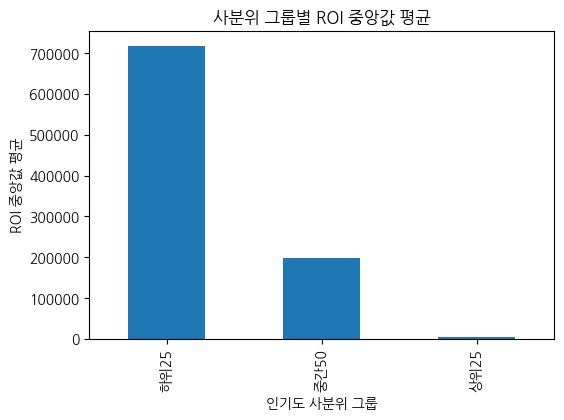

In [8]:
# =========================
# ROI 중앙값 기반 ANOVA + Tukey HSD
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd



# 숫자 변환
for c in ["ROI", "SR", "popularity"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# popularity > 0 유지
df = df[df["popularity"] > 0].copy()

# ROI 스케일 판별
roi_threshold = 250.0 if df["ROI"].dropna().median() > 10 else 2.5

# 필터
filtered = df[(df["ROI"] >= roi_threshold) & (df["SR"] >= 2)].copy()

# =========================
# 2) 감독 단위 집계 (ROI 중앙값)
# =========================
grouped = (filtered
           .dropna(subset=["director","popularity","ROI"])
           .groupby("director", as_index=False)
           .agg(평균_popularity=("popularity","mean"),
                중앙값_ROI=("ROI","median"))
          )

# =========================
# 3) popularity 사분위 그룹 나누기
# =========================
q25 = grouped["평균_popularity"].quantile(0.25)
q75 = grouped["평균_popularity"].quantile(0.75)

def quartile_label(x, q25, q75):
    if x < q25:
        return "하위25"
    elif x >= q75:
        return "상위25"
    else:
        return "중간50"

grouped["인기도_사분위"] = grouped["평균_popularity"].apply(lambda x: quartile_label(x, q25, q75))

print("사분위 그룹 분포:\n", grouped["인기도_사분위"].value_counts())

# =========================
# 4) ANOVA
# =========================
roi_low  = grouped.loc[grouped["인기도_사분위"] == "하위25", "중앙값_ROI"].values
roi_mid  = grouped.loc[grouped["인기도_사분위"] == "중간50", "중앙값_ROI"].values
roi_high = grouped.loc[grouped["인기도_사분위"] == "상위25", "중앙값_ROI"].values

f_stat, p_val = stats.f_oneway(roi_low, roi_mid, roi_high)
print("\n[ANOVA] F =", f_stat, ", p =", p_val)

model = smf.ols("중앙값_ROI ~ C(인기도_사분위)", data=grouped).fit()
anova_res = anova_lm(model, typ=2)
print("\n[ANOVA: statsmodels]\n", anova_res)

# =========================
# 5) Tukey HSD
# =========================
tukey = pairwise_tukeyhsd(endog=grouped["중앙값_ROI"],
                          groups=grouped["인기도_사분위"],
                          alpha=0.05)
print("\n[Tukey HSD]\n", tukey)

# =========================
# 6) 시각화
# =========================
plt.figure(figsize=(6,4))
grouped.boxplot(column="중앙값_ROI", by="인기도_사분위")
plt.title("사분위 그룹별 중앙값_ROI 분포 (ROI≥{:.0f}, SR≥2, popularity>0)".format(roi_threshold))
plt.suptitle("")
plt.xlabel("인기도 사분위 그룹")
plt.ylabel("ROI 중앙값")
plt.show()

plt.figure(figsize=(6,4))
group_means = grouped.groupby("인기도_사분위")["중앙값_ROI"].mean().reindex(["하위25","중간50","상위25"])
group_means.plot(kind="bar")
plt.title("사분위 그룹별 ROI 중앙값 평균")
plt.xlabel("인기도 사분위 그룹")
plt.ylabel("ROI 중앙값 평균")
plt.show()


사분위 그룹 분포:
 인기도_사분위
중간50    788
하위25    394
상위25    394
Name: count, dtype: int64

[ANOVA: log_ROI] F = 16.294058670069685 , p = 9.905696529527646e-08

[ANOVA: statsmodels]
                  sum_sq      df          F        PR(>F)
C(인기도_사분위)    46.190110     2.0  16.294059  9.905697e-08
Residual    2229.556339  1573.0        NaN           NaN

[Tukey HSD: log_ROI]
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  상위25   중간50   0.0289 0.9182 -0.1434 0.2012  False
  상위25   하위25   0.4137    0.0  0.2147 0.6127   True
  중간50   하위25   0.3848    0.0  0.2125 0.5571   True
---------------------------------------------------


<Figure size 600x400 with 0 Axes>

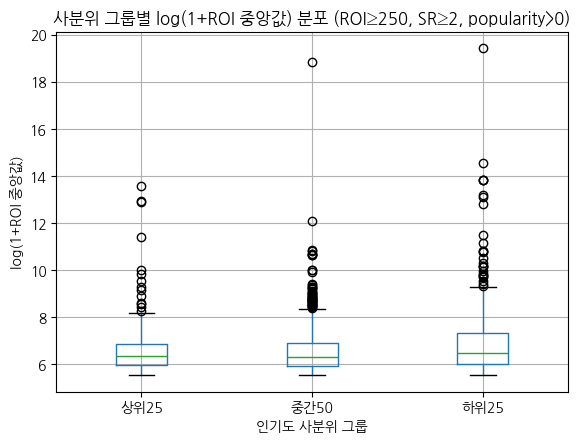

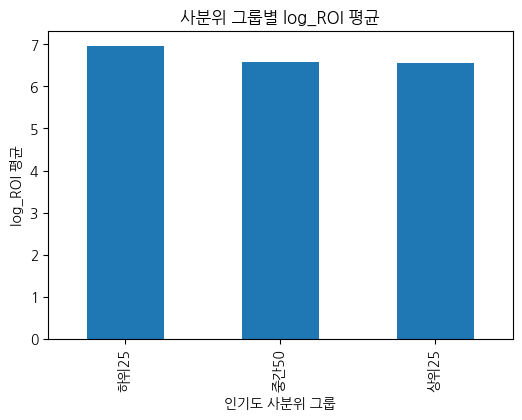